# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def balance_transform(elem):
    return float(elem[:-2].replace(',','.').replace(' ',''))

df['balance'] = df['balance'].apply(lambda x: balance_transform(x) if pd.notna(x) else x)

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df.balance.median(), inplace=True)

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.education = df.education.apply(lambda x: df.education.describe()['top'] if x == 'unknown' else x)
df.job = df.job.apply(lambda x:df.job.describe()['top'] if x == 'unknown' else x)
mask = (df.education == df.education.describe()['top']) & (df.job == df.job.describe()['top'])
df[mask]['balance'].mean()

1598.8829787234042

### Задание 6

In [8]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature, left = 1.5, right = 1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    print(f'Lower bound - {lower_bound}')
    upper_bound = quartile_3 + (iqr * right)
    print(f'Upper bound - {upper_bound}')
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

outliers, cleaned = outliers_iqr(df, 'balance', 1.5, 1.5)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
df = cleaned

Lower bound - -2241.0
Upper bound - 4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [9]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df.deposit.value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [10]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<Figure size 432x288 with 0 Axes>

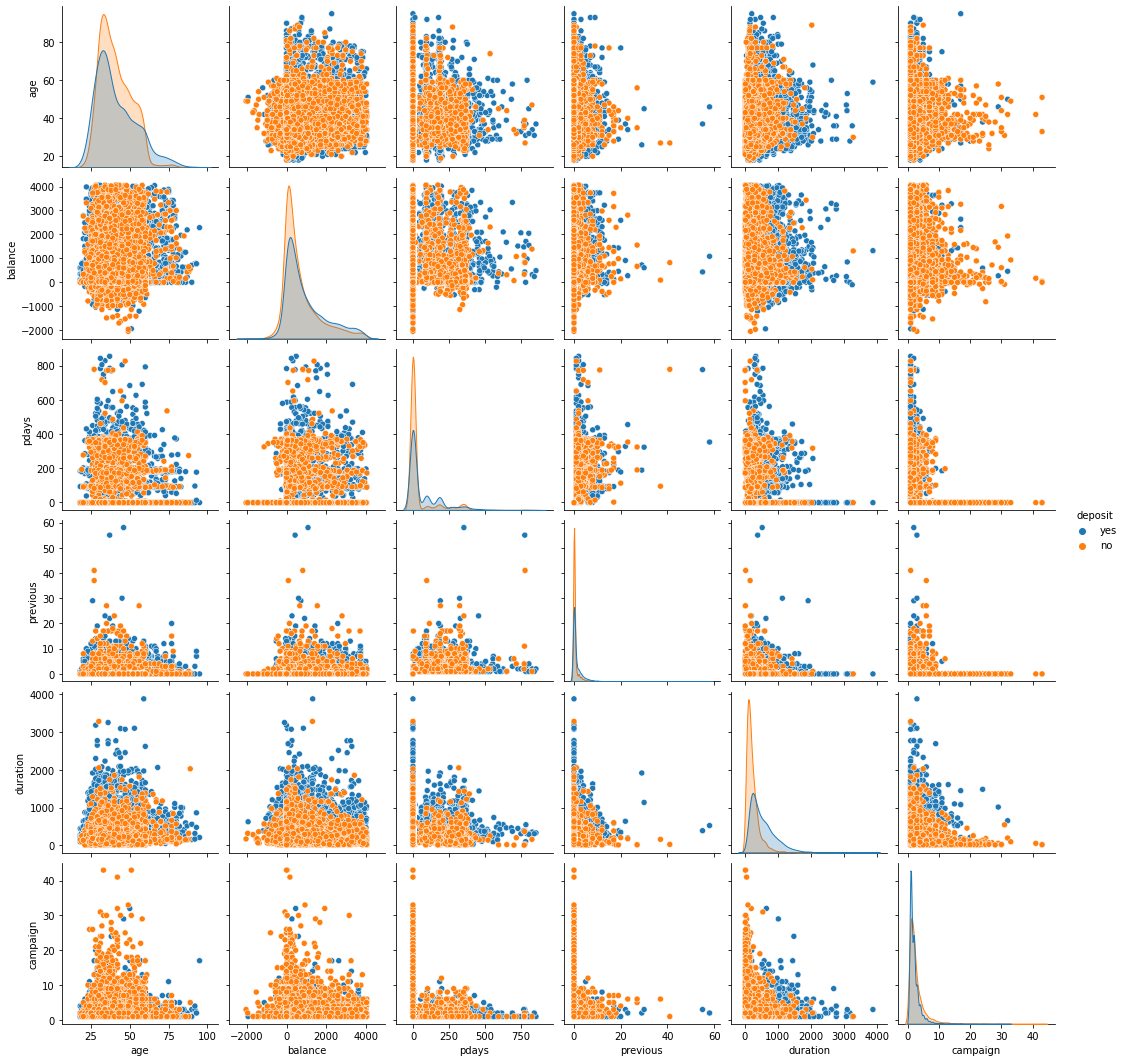

In [11]:
to_plot = ["age", "balance", 'pdays', "previous", 'duration','campaign','deposit']
plt.figure()
sns.pairplot(df[to_plot], hue='deposit')
plt.show();

#### Вывод: Каких либо значимых зависимостей между количественными признаками не выявлено. Практически все признаки распределены логнормально, что обуславливает аномалии и выбросы в большую сторону

### Задания 4 и 5

In [12]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include=[object])
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [13]:
df['deposit_bin'] = df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)

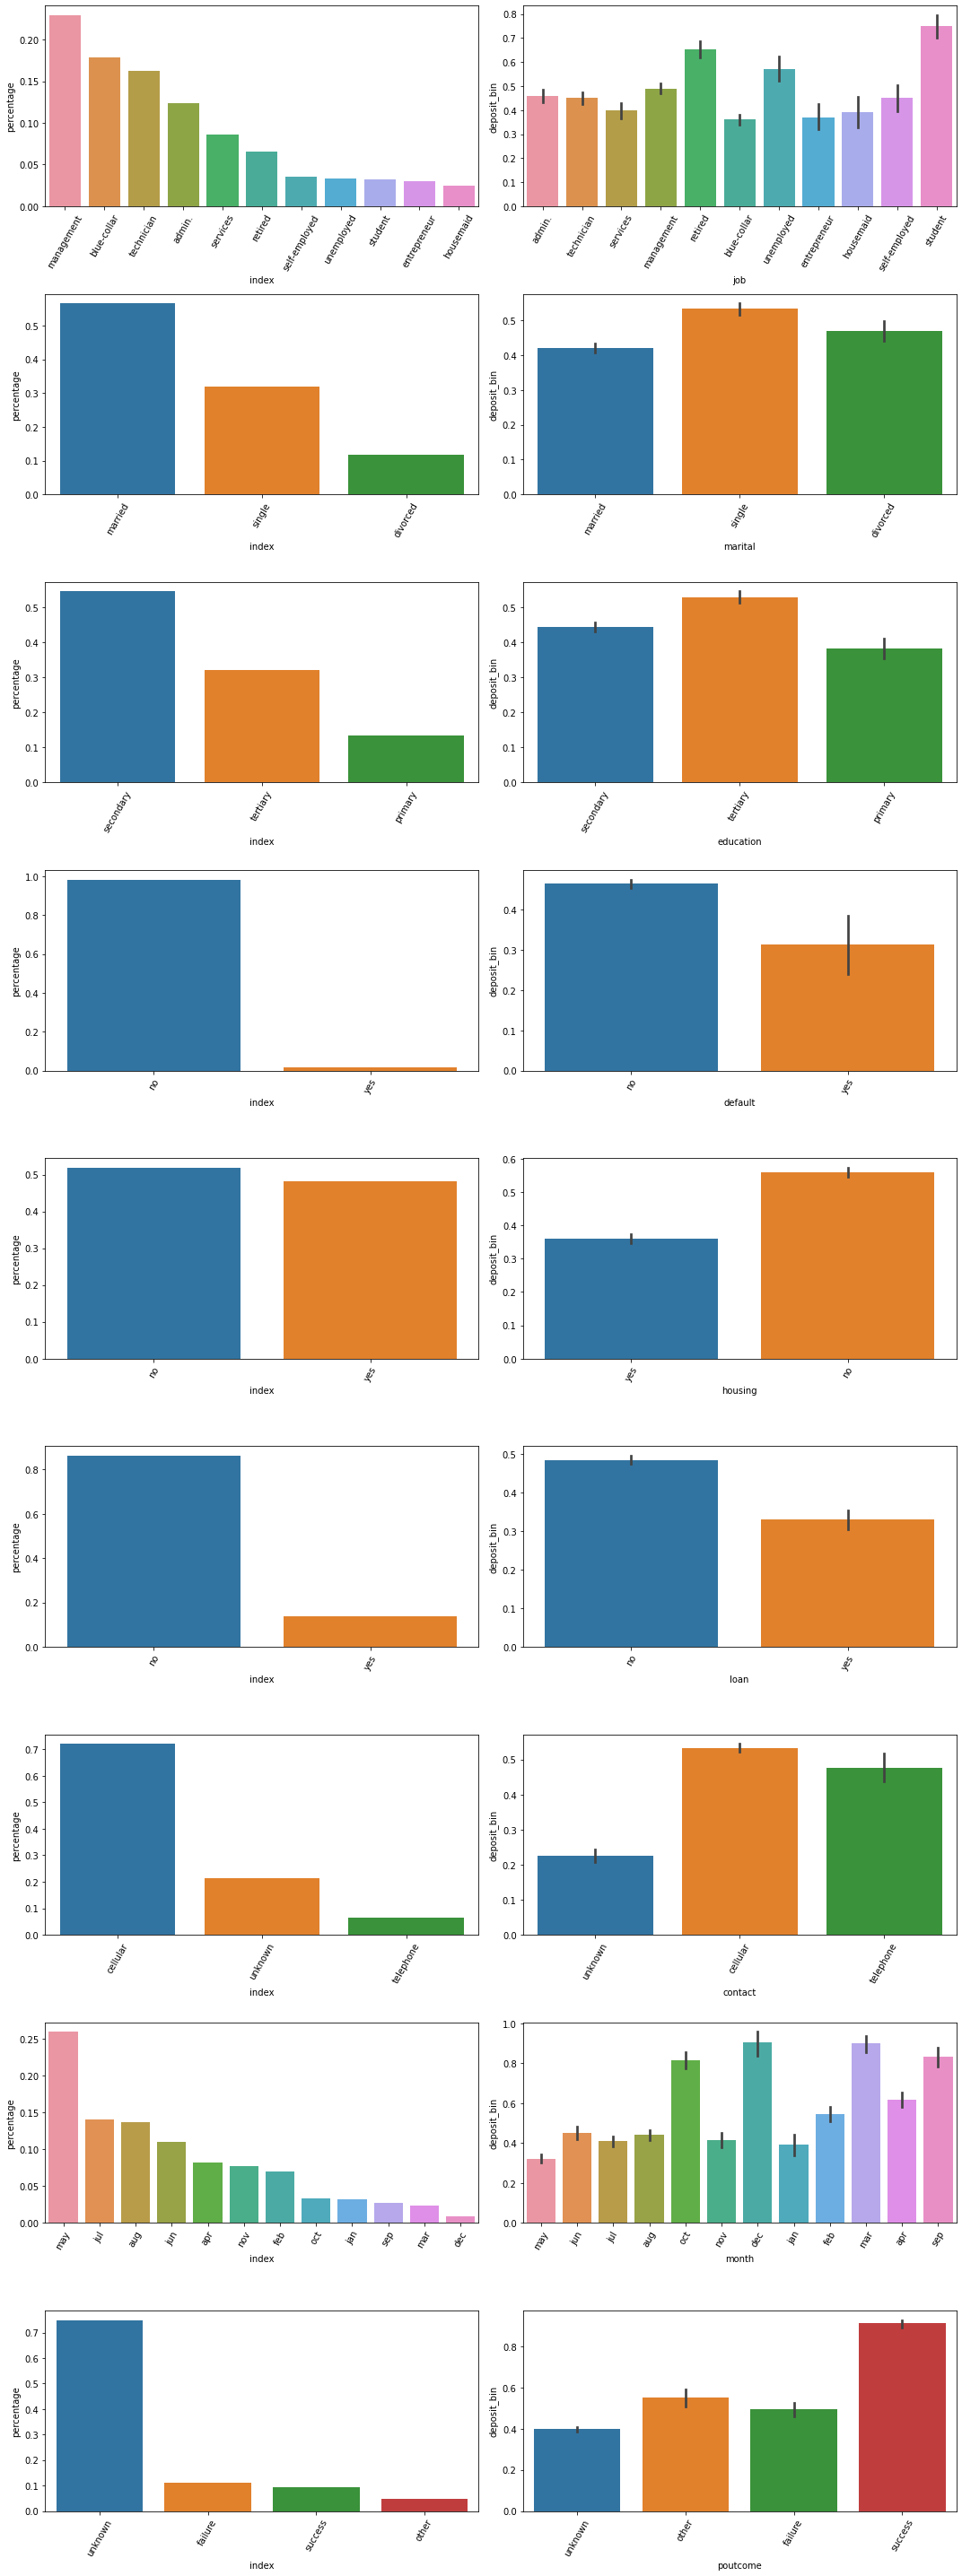

In [14]:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features.remove('deposit')
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (df[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей открывших депозит в зависимости от категории
    mean_barplot = sns.barplot(data=df, x=feature, y='deposit_bin', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

In [15]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

### Задание 7

In [16]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
months = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_open_depo = df.groupby('month')['deposit'].value_counts()
refuse_by_month = {}
for m in months:
    res = month_open_depo.loc[(m, 'no')] / (month_open_depo.loc[(m, 'yes')] + month_open_depo.loc[(m, 'no')])
    refuse_by_month[m] = res
max(refuse_by_month, key=refuse_by_month.get)

'may'

### Задание 8

In [17]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def group_by_age(x):
    if x < 30:
        return '< 30'
    elif x < 40 and x >=30:
        return '30 - 40'
    elif x < 50 and x >=40:
        return '40 - 50'
    elif x < 60 and x >= 50:
        return '50 - 60'
    else:
        x >= 60
        return '60+'

df['age_group'] = df.age.apply(group_by_age)

In [18]:
df.groupby('age_group')['deposit'].value_counts()

age_group  deposit
30 - 40    no         2245
           yes        1716
40 - 50    no         1444
           yes         938
50 - 60    no          984
           yes         670
60+        yes         496
           no          157
< 30       yes         861
           no          594
Name: deposit, dtype: int64

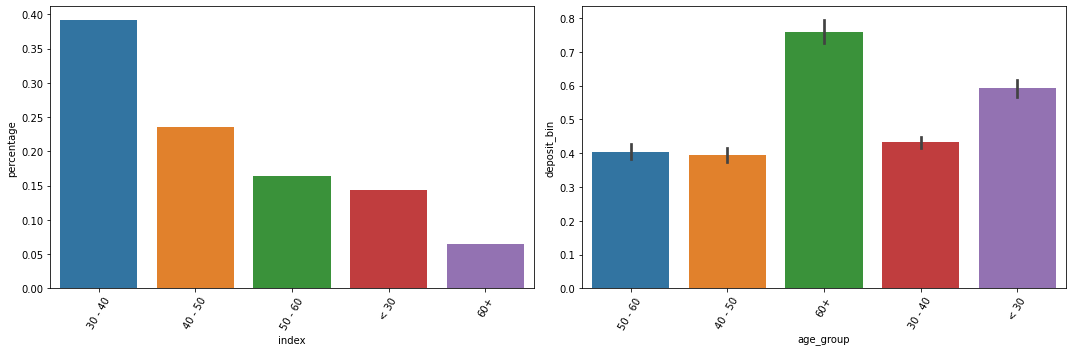

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
data = (df['age_group'].value_counts(normalize=True)
            .sort_values(ascending=False)
            .rename('percentage')
            .reset_index())
count_barplot = sns.barplot(data=data, x='index', y='percentage', ax=axes[0])
count_barplot.xaxis.set_tick_params(rotation=60)
mean_barplot = sns.barplot(data=df, x='age_group', y='deposit_bin', ax=axes[1])
mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout()

### Задания 9 и 10

In [20]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
df.groupby('marital')['deposit'].value_counts()

marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    yes        1716
          no         1497
Name: deposit, dtype: int64

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
df.groupby('education')['deposit'].value_counts()

education  deposit
primary    no          832
           yes         517
secondary  no         3066
           yes        2451
tertiary   yes        1713
           no         1526
Name: deposit, dtype: int64

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
df.groupby('job')['deposit'].value_counts()

job            deposit
admin.         no          672
               yes         574
blue-collar    no         1155
               yes         652
entrepreneur   no          189
               yes         111
housemaid      no          153
               yes          99
management     no         1180
               yes        1135
retired        yes         432
               no          231
self-employed  no          197
               yes         161
services       no          523
               yes         345
student        yes         245
               no           81
technician     no          900
               yes         738
unemployed     yes         189
               no          143
Name: deposit, dtype: int64

### Вывод: 
* Наиболее распространенный вид занятости среди клиентов - Менеджмент. Одни из самых наименее распространенных - Retired и Student, хотя среди таких клиентов наибольший процент размещения депозита
* Маркетинговая компания проходила каждый месяц. Наибольший процент неудач наблюдается в мае, хотя в этом месяца наибольшее количество контактов. Совершенно обратная ситуация наблюдается в декабре, когда при наименьшем количестве контактов имеется наибольший процент успеха.
* Наиболее распространенное семейноеположение среди клиентов - Женатые, однако опять же у этой группы наименьшая доля размещения депозита
* Наиболее распространенное образование среди клиентов - Secondary
* Подавляющая доля клиентов, отреагировавшая на предыдущую маркетинговую компанию, повторно разместили депозит. К сожалению доля таких клиентов от общей массы минимальна.
* Наибольшая доля клиентов воспользовавшаяся депозитом в банке наблюдается в возрастной категории 60+ и что странно < 30. Но опять же это самые малочисленные группы клиентов.

### Задание 11

In [23]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
mask = df['deposit'] == 'yes'
pivot = df[mask].pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')
pivot

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


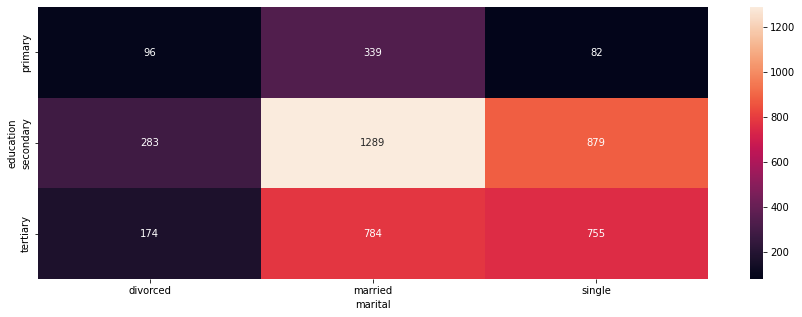

In [24]:
plt.figure(figsize = (15, 5))
sns.heatmap(pivot, annot = True, fmt='.0f');

In [25]:
mask = df['deposit'] == 'no'
pivot = df[mask].pivot_table(index='education', columns='marital', values='deposit', aggfunc='count')
pivot

marital,divorced,married,single
education,,,
primary,91,641,100
secondary,370,1830,866
tertiary,163,832,531


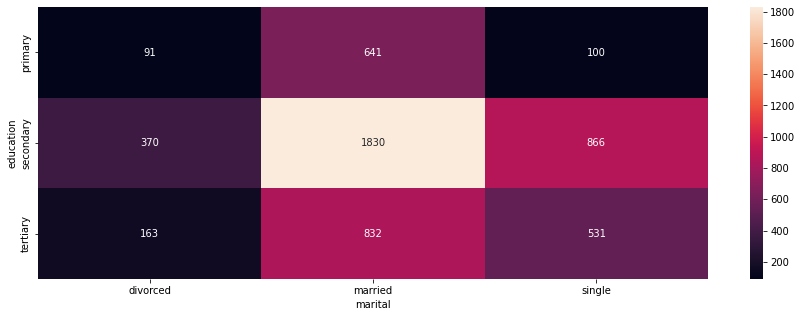

In [26]:
plt.figure(figsize = (15, 5))
sns.heatmap(pivot, annot = True, fmt='.0f');

### Вывод: Распределение клиентов банка по семейному положению и уровню образования примерно одинаково как для разместивших депозит, так и для не принявших предложение, таким образом фактор образования и семейного положения не влияет на факт открытия депозита

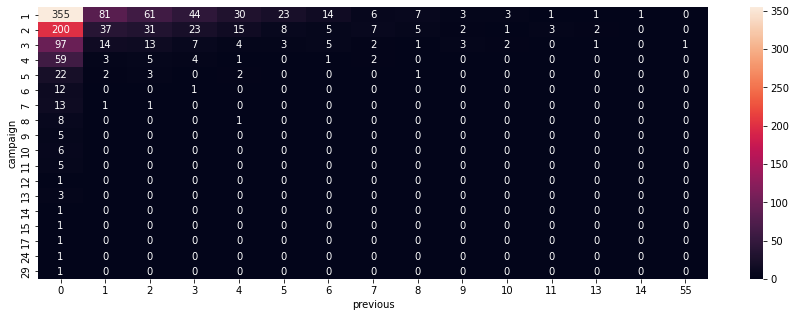

In [27]:
# На основе анализа категоральных признаков мы выяснили, что наибольшая группа клиентов в которой наименьшая доля открывших депозиты это люди семейные со средним образованием.
# Давайте проанализируем каким образом проводимые маркетинговые компании могут влиять на факт открытимя депозита.
# Для этого выделим интересующую нас группу семейных клиентов со средним образованием открывших депозит и проанализируем как меняется их количество в зависимости от количества контактов 
# в процессе маркетинговых компаний

mask = (df.marital == 'married') & (df.education == 'secondary') & (df.deposit == 'yes')
test = df[mask].pivot_table(index='campaign', columns='previous', values='deposit', aggfunc='count', fill_value=0)
plt.figure(figsize = (15, 5))
sns.heatmap(test, annot = True, fmt='.0f');


### Вывод: Количество контактов текущей маркетинговой компании не является фактором, побуждающим открыть депозит, а прошлую компанию можно считать провальной

## Часть 3: преобразование данных

### Задание 1

In [28]:
# преобразуйте уровни образования
le = LabelEncoder()
df.education = le.fit_transform(df.education)
print(le.classes_)
df.age_group = le.fit_transform(df.age_group)
print(le.classes_)

['primary' 'secondary' 'tertiary']
['30 - 40' '40 - 50' '50 - 60' '60+' '< 30']


### Задания 2 и 3

In [29]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df = df.drop('deposit', axis=1)
df.rename(columns={'deposit_bin': 'deposit'}, inplace=True)
df['default'] = df['default'].apply(lambda x: 1 if x == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda x: 1 if x == 'yes' else 0)

### Задание 4

In [30]:
# создайте дамми-переменныеfrom
import category_encoders as ce

cols_to_oh_encode = ['job', 'marital', 'contact', 'month', 'poutcome']
oh_encoder = ce.OneHotEncoder(cols=cols_to_oh_encode, use_cat_names=True)
df_onehot = oh_encoder.fit_transform(df[cols_to_oh_encode])
df = pd.concat([df, df_onehot], axis=1)

### Задания 5 и 6

<AxesSubplot: >

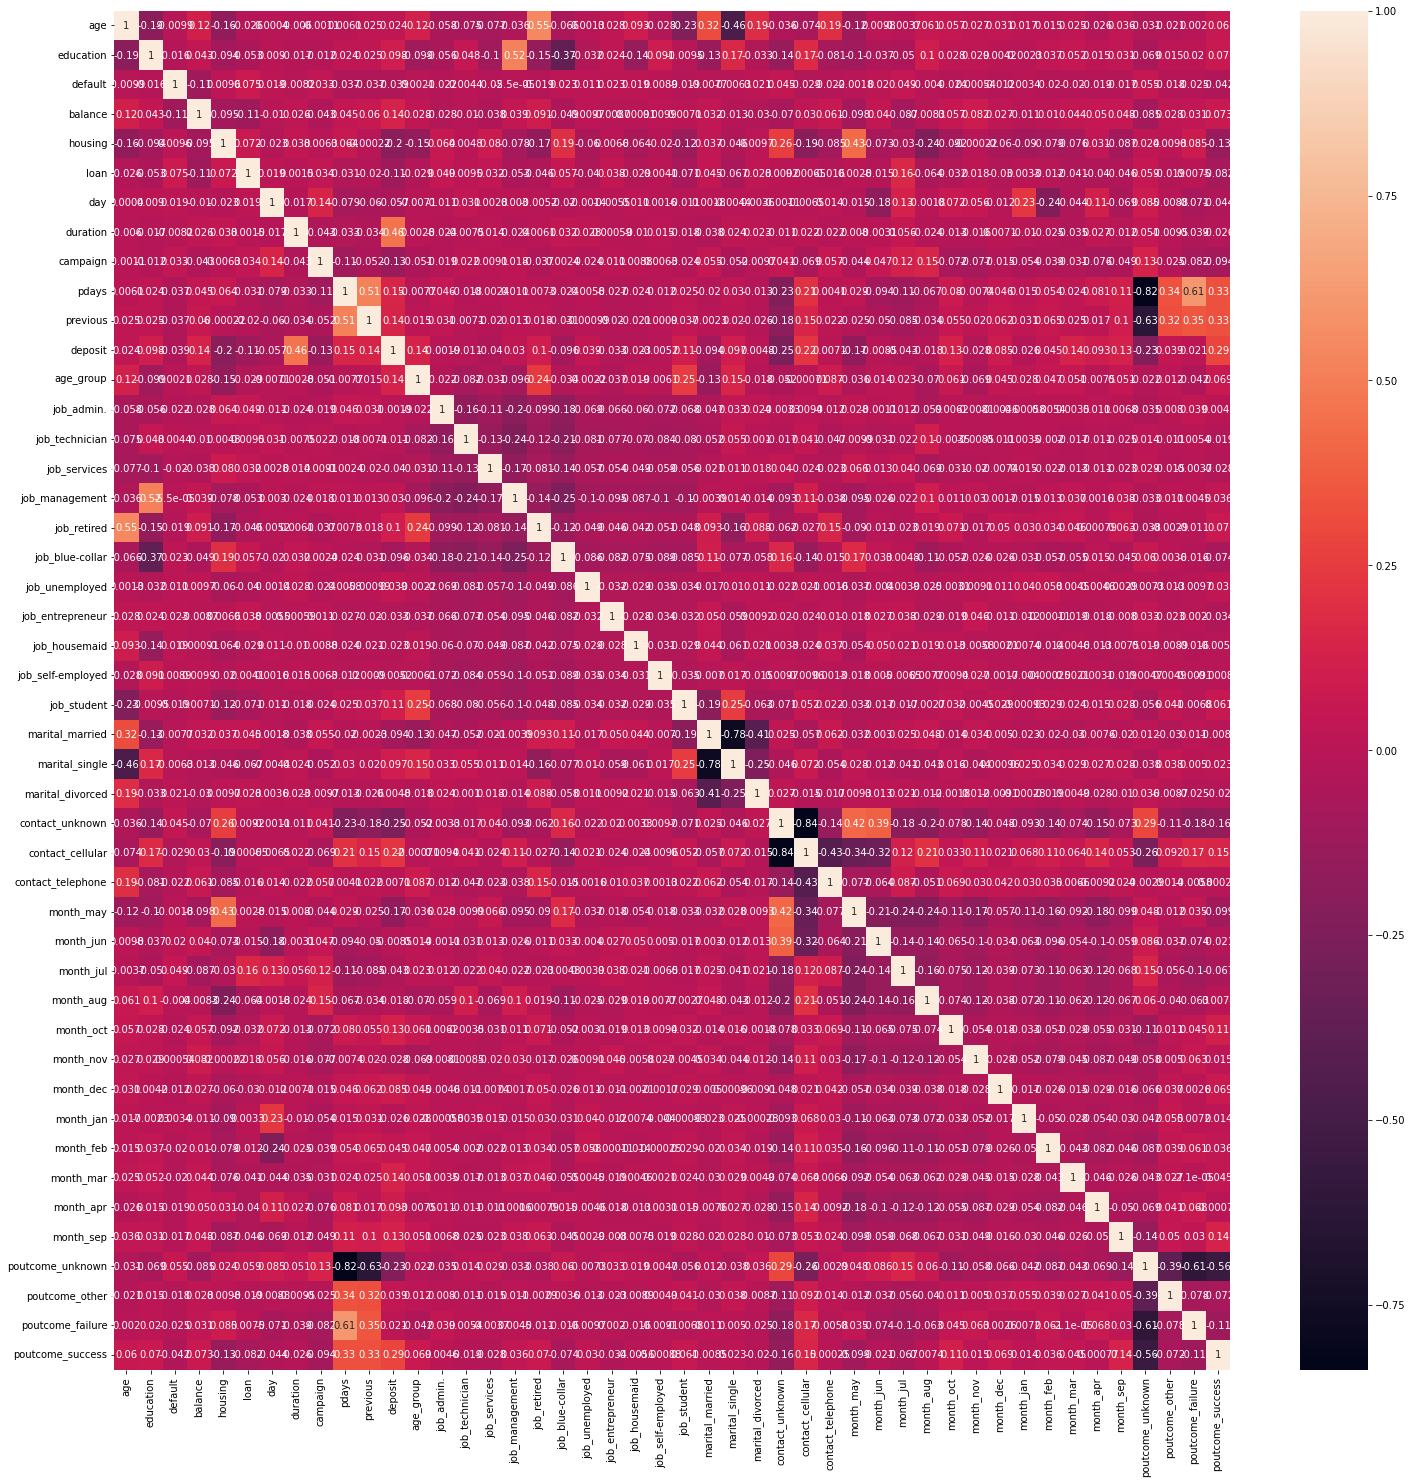

In [31]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.rcParams['figure.figsize'] = (25,25)
sns.heatmap(df.corr(), annot=True)

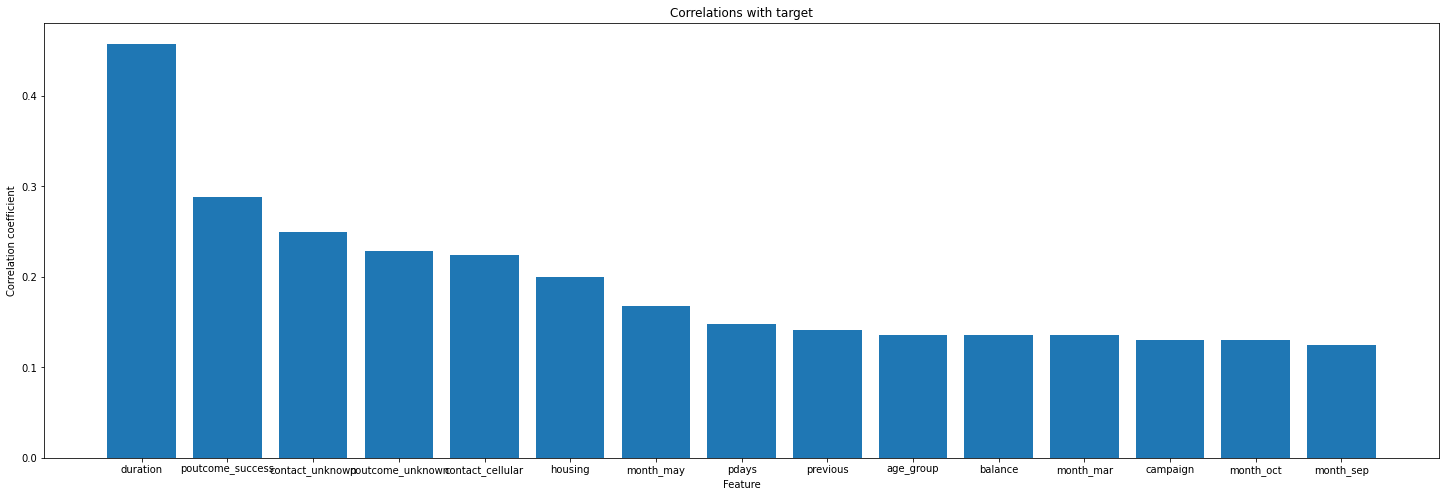

In [32]:
#Вычисляем модуль корреляции
corr_with_target = df.corr()['deposit'].abs().sort_values()
#Удаляем корреляцию целевой переменной с самой собой
corr_with_target = corr_with_target.drop('deposit')
corr_with_target = corr_with_target.nlargest(15)
#Строим столбчатую диаграмму корреляций
fig, ax = plt.subplots(figsize=(25, 8)) #фигура+координатная плоскость
ax.bar(corr_with_target.index, corr_with_target.values) #столбчатая диаграмма
ax.set_title('Correlations with target') #название графика
ax.set_xlabel('Feature') #название оси x
ax.set_ylabel('Сorrelation coefficient'); #название оси y

In [33]:
data = df.dtypes
cols_to_drop = data[data.values == object].index
df = df.drop(cols_to_drop, axis=1)

### Задания 7 и 8

In [34]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [35]:
# рассчитайте необходимые показатели
print(X_test.shape)
print(y_test.mean())

(3335, 45)
0.46326836581709147


### Задание 9

In [36]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
cols_to_leave = selector.get_feature_names_out()

for col in X_train.columns:
    if col not in cols_to_leave:
        X_train.drop(col, axis=1, inplace=True)
        X_test.drop(col, axis=1, inplace=True)

feature = X_train.columns
        

### Задание 10

In [37]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [38]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [39]:
#Делаем предсказание класса
y_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
print('Accuracy: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy: 0.805


### Задания 2,3,4

In [40]:
#Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    #min_samples_leaf=5,
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

### Задание 5

In [41]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7,10],
              'max_depth': [3, 5, 7],
              }
            
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42), 
    #estimator=tree.DecisionTreeClassifier(), 
    param_grid=param_grid
    )  
grid_search.fit(X_train, y_train) 
y_train_pred = grid_search.predict(X_train)
print('f1_score на обучающем наборе: {:.3f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search.predict(X_test)
print('f1_score на тестовом наборе: {:.3f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

f1_score на обучающем наборе: 0.825
f1_score на тестовом наборе: 0.807
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [42]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf=5,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [43]:
#Делаем предсказание класса
y_pred = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

print(f'F1_test - {metrics.f1_score(y_test, y_pred_test)}')
print(metrics.classification_report(y_test, y_pred_test))

F1_test - 0.8154724159797083
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [44]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf=5,
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test)
print(f'F1_test - {metrics.f1_score(y_test, y_pred)}')
print(metrics.classification_report(y_test, y_pred))

F1_test - 0.8167672276913305
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [45]:
# объедините уже известные вам алгоритмы с помощью стекинга 
from sklearn.ensemble import StackingClassifier

estimators = [
    ('lr', linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)),
    ('dt', tree.DecisionTreeClassifier(criterion='entropy', max_depth= 7, min_samples_split= 10, random_state=42)),
    ('gb', GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=5, min_samples_leaf=5, random_state=42))
    ]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000))

# Обучаем модель
reg.fit(X_train, y_train)

StackingClassifier(estimators=[('lr',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=7,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42,
                                                      solver='sag'))

In [46]:
# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test)
print(metrics.classification_report(y_test, y_pred_stack))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

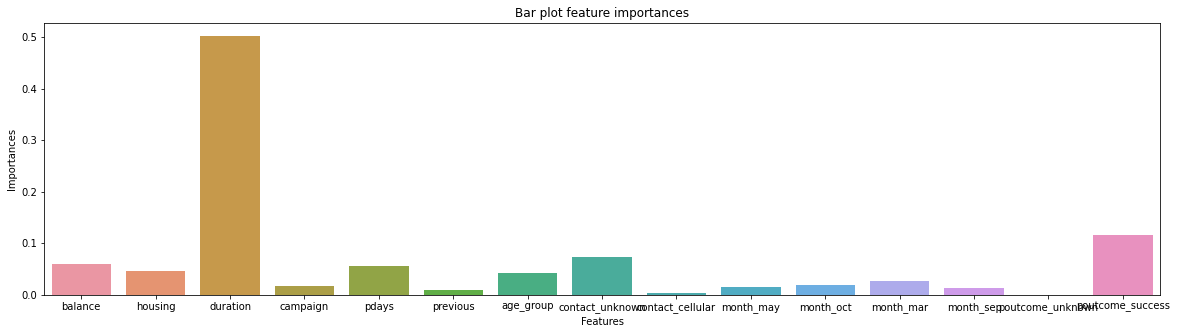

In [48]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(20, 5)) #фигура + координатная плоскость
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);

ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

#### Вывод: Предлагаю следующие гипотезы касательно важности признаков Duration, poutcome_success и contact_unknown для модели Градиентного бустинга.
Данные признаки имеют наибольшую корреляцию с целевым признаком, кроме того:
* Duration - в данном признаке данные значительно превышают значения других признаков и имеют сущесвтенные выбросы. Модель градиентного бустинга требует масштабированных данных. В нашем случае мы использовали MinMaxScaler, который чувствителен к выбросам. В данном случае уместнее было бы использовать RobustScaler.
* Poutcome_success - В процессе разведочного анализа мы обнаружили, что более 90% клиентов, отреагировавшие на прошлую рекламную компанию, откликаются и на текущую.

### Задания 6,7,8

In [49]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=40)

[I 2023-04-20 23:51:21,294] A new study created in memory with name: RandomForestClassifier
[I 2023-04-20 23:51:22,071] Trial 0 finished with value: 0.8509570128647631 and parameters: {'n_estimators': 130, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8509570128647631.
[I 2023-04-20 23:51:23,290] Trial 1 finished with value: 0.8502657080337606 and parameters: {'n_estimators': 197, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8509570128647631.
[I 2023-04-20 23:51:24,421] Trial 2 finished with value: 0.8466718872357086 and parameters: {'n_estimators': 181, 'max_depth': 25, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8509570128647631.
[I 2023-04-20 23:51:25,540] Trial 3 finished with value: 0.9024466750313677 and parameters: {'n_estimators': 130, 'max_depth': 16, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9024466750313677.
[I 2023-04-20 23:51:26,383] Trial 4 finished with value: 0.8668122270742359 and parameters: {'n

In [50]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 191, 'max_depth': 26, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [51]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на тренировочном наборе: {:.4f}'.format(metrics.f1_score(y_train, y_train_pred)))
#print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print(metrics.classification_report(y_test, y_test_pred))

f1_score на тренировочном наборе: 0.9235
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1790
           1       0.80      0.84      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



In [52]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

In [53]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

In [54]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")